In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from utils import ImgDataset
from network import SimpleCNN, KeypointNet

from IPython.display import display

import numpy as np
from PIL import Image, ImageDraw

# Img2Img Model

In [2]:
model_path = './models/simpleCNN_L3.249_07-12-2021_19-41-06.pth'

model = SimpleCNN()
model.load_state_dict(torch.load(model_path))
model.eval()

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)

## Load Data

In [3]:
input_transform = transforms.ToTensor()

pred_trans = transforms.ToPILImage(mode='L')

feature_trans = transforms.ToPILImage(mode='RGB')

testset = ImgDataset('./data/DJI_0013', transform=input_transform, target_transform=input_transform)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

dataiter = iter(testloader)

## Predict

Feature:


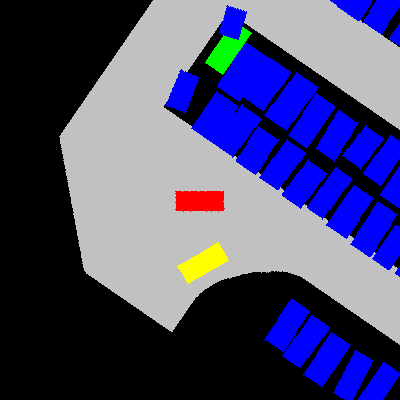

Label:


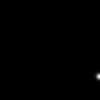

Pred


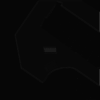

In [32]:
inputs, labels = dataiter.next()

preds = model(inputs)

# Transform back to image

pred_heatmap = pred_trans(preds[0, 0])
feature_image = feature_trans(inputs[0])
label_heatmap = Image.fromarray(np.floor(labels[0, 0].numpy() * 255).astype('uint8'))

# Display
print("Feature:")
display(feature_image)

print("Label:")
display(label_heatmap)

print("Pred")
display(pred_heatmap)

# Img2Kpt Model

In [2]:
model_path = './models/KeypointNet_L0.019_07-27-2021_11-50-46.pth'

model = KeypointNet()
model.load_state_dict(torch.load(model_path))
model.eval()

KeypointNet(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): ReL

## Load Data

In [7]:
input_transform = transforms.ToTensor()

feature_trans = transforms.ToPILImage(mode='RGB')

def kpt_normalize(keypoint):
    return torch.from_numpy(keypoint / 400).float()

testset = ImgDataset('./data/DJI_0012', transform=input_transform, target_transform=kpt_normalize)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

dataiter = iter(testloader)

## Predict

Label: tensor([[0.5150, 0.4975]])


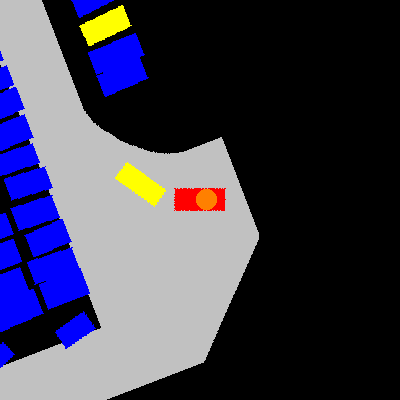

Pred: tensor([[0.5987, 0.5716]], grad_fn=<SigmoidBackward>)


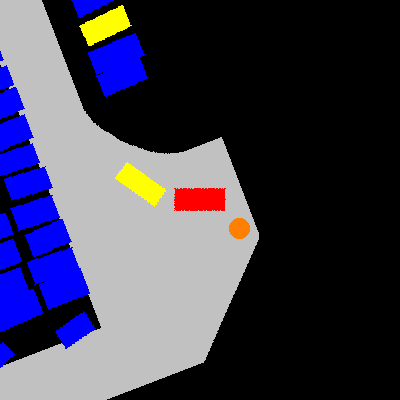

In [24]:
inputs, labels = dataiter.next()

preds = model(inputs)

feature_img = feature_trans(inputs[0])

label_img = feature_img.copy()

label_draw = ImageDraw.Draw(label_img)
label_loc = (labels[0] * 400).int()
label_draw.ellipse((label_loc[0]-10, label_loc[1]-10, label_loc[0]+10, label_loc[1]+10), fill=(255, 128, 0))


pred_img = feature_img.copy()

pred_draw = ImageDraw.Draw(pred_img)
pred_loc = (preds[0] * 400).int()
pred_draw.ellipse((pred_loc[0]-10, pred_loc[1]-10, pred_loc[0]+10, pred_loc[1]+10), fill=(255, 128, 0))

print("Label:", labels)

display(label_img)

print("Pred:", preds)

display(pred_img)